In [1]:
import os
import torch
from pathlib import Path
import torchvision
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import shutil
import random
device= 'cuda' if torch.cuda.is_available() else 'cpu'

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

#About Dataset

**Context**

This dataset is being used for classifying the use of land in geospatial images. The end goal for the classification is that the top 2 uses of land in an image are given as output to the user.

**Content**

This dataset contains images belonging to the EuroSat dataset. There are 2 folders, namely,

`EuroSAT` → Contains RGB images collected from the Sentinel Dataset.
`EuroSATallBands` → Contains .tif files which have all the bands of the spectrum as collected from the Sentinel-2 satellite.

Each image is 64x64 pixels with a Ground Sampling Distance of 10m. They were all collected from the Sentinel-2 satellite

Source :
[Euro-Sat Dataset](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset)



In [ ]:
dir='/content/map_data'
if os.path.isdir(dir):
  print('Data Already Available')
else:
  !git clone https://github.com/Zeepratik4444/Snippents_ML
  !mv Snippents_ML/kaggle.json .
  !rm -rf Snippents_ML
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !kaggle datasets download -d apollo2506/eurosat-dataset
  !unzip eurosat-dataset

In [3]:
dir='/content/map_data'
if os.path.isdir(dir):
  print('Data Already Available')
else:
  os.makedirs('/content/map_data')
  map_data_train_path='/content/map_data/train'
  map_data_test_path='/content/map_data/test'
  train_agriculture='/content/map_data/train/agriculture'
  train_settlements='/content/map_data/train/settlements'
  train_waterbodies='/content/map_data/train/waterbodies'
  test_agriculture='/content/map_data/test/agriculture'
  test_settlements='/content/map_data/test/settlements'
  test_waterbodies='/content/map_data/test/waterbodies'
  os.makedirs(map_data_train_path)
  os.makedirs(map_data_test_path)
  os.makedirs(train_agriculture)
  os.makedirs(train_settlements)
  os.makedirs(train_waterbodies)
  os.makedirs(test_agriculture)
  os.makedirs(test_settlements)
  os.makedirs(test_waterbodies)

## Preparing data by taking out data which we want to train in the model.

In this we will try to classify if the land use.

The three categories are:
* Agricultural land
* Settlements
* Water Bodies

In [4]:
def prepare_data(src_dir,train_dir,test_dir):
  files=os.listdir(src_dir)
  test_proportion=0.25

  num_test_files=int(len(files)* test_proportion)

  test_files= random.sample(files,num_test_files)

  for file in test_files:
    shutil.move(os.path.join(src_dir, file), os.path.join(test_dir, file))

  for file in os.listdir(src_dir):
    shutil.move(os.path.join(src_dir, file), os.path.join(train_dir, file))



In [5]:
prepare_data('/content/EuroSAT/AnnualCrop',train_agriculture,test_agriculture)
prepare_data('/content/EuroSAT/PermanentCrop',train_agriculture,test_agriculture)
prepare_data('/content/EuroSAT/Residential',train_settlements,test_settlements)
prepare_data('/content/EuroSAT/Industrial',train_settlements,test_settlements)
prepare_data('/content/EuroSAT/River',train_waterbodies,test_waterbodies)
prepare_data('/content/EuroSAT/SeaLake',train_waterbodies,test_waterbodies)



In [6]:
for dirpath, dirnames, filenames in os.walk('map_data'):
      print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'map_data'.
There are 3 directories and 0 images in 'map_data/test'.
There are 0 directories and 1375 images in 'map_data/test/waterbodies'.
There are 0 directories and 1375 images in 'map_data/test/agriculture'.
There are 0 directories and 1375 images in 'map_data/test/settlements'.
There are 3 directories and 0 images in 'map_data/train'.
There are 0 directories and 4125 images in 'map_data/train/waterbodies'.
There are 0 directories and 4125 images in 'map_data/train/agriculture'.
There are 0 directories and 4125 images in 'map_data/train/settlements'.


In [45]:
import glob
import os
import cv2
import matplotlib.pyplot as plt

def show_images_in_subplot(dataset_directory):
    # Use glob to get the file paths
    image_paths = glob.glob(os.path.join(dataset_directory,'*/*.jpg'))
    random_image_paths = random.sample(image_paths, k=9)



    # Create a subplot for displaying 9 images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        if i < len(random_image_paths):
            image = cv2.imread(random_image_paths[i])  # Read the image using OpenCV
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with matplotlib
            ax.imshow(image)
            ax.axis('off')  # Turn off axis
            ax.set_title(Path(random_image_paths[i]).parent.stem)

    # Display the plot
    plt.show()



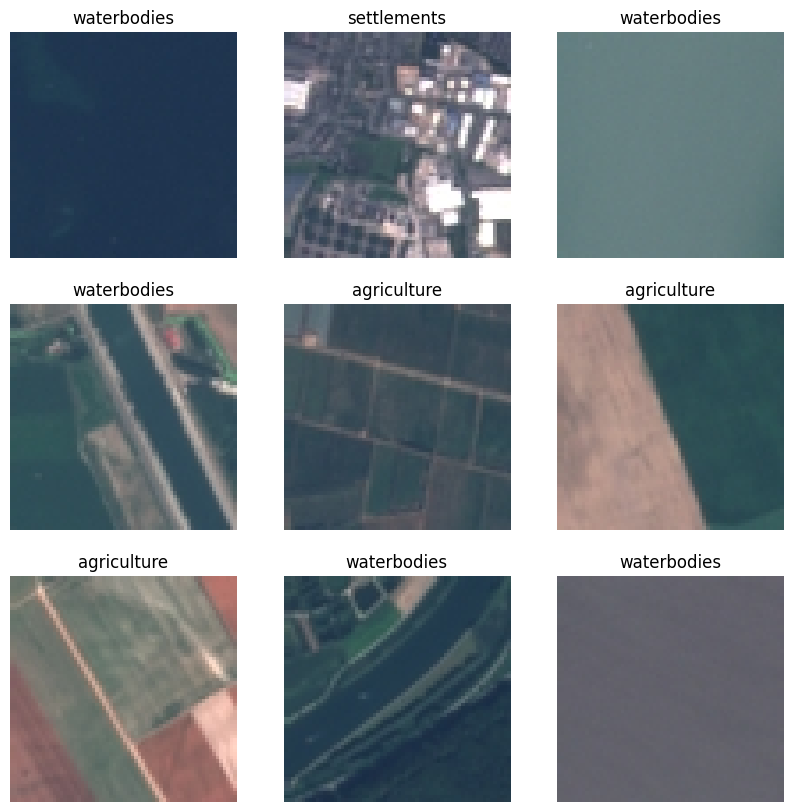

In [46]:
show_images_in_subplot(map_data_train_path)

## The structure of our data files are as such
```
content/
└── map_data/
    ├── train/
    |   ├── agriculture -4125 images.jpg
    │   ├── settlements -4125 images.jpg
    │   └── waterbodies -4125 images.jpg
    ├── test/
        ├── agriculture -1375 images.jpg
        ├── settlements -1375 images.jpg
        └── waterbodies -1375 images.jpg
  
```

We need to create datalaoder function in order to bring in image data perform some transforms and create batch size to make nueral network seamless.

* train_dir -Takes in training directory path
* test_dir - Takes in testing directory path
* transform - Takes in the series of transforms we want to perform on data in order to get more accurate predicitions.
* batch_size - Takes in no of batches we want our model to learn at once, helps in making the cpu less burdened
* num_workers- Takes in the number of cores our cpu or gpu has to help learning faster.

In [7]:
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int):
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

## We are EffecientNetB2 for our current project and using transfer learning to create the best predictions out of our data.

In [8]:
import torchvision
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
  kwargs.pop("check_hash")
  return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    #  Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    #  Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    #  Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms


In [9]:
effnetb2_model,effnetb2_transforms=create_effnetb2_model(num_classes=3)

effnetb2_transforms

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 183MB/s]


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
summary(model=effnetb2_model,
        input_size=[1,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]    [1, 16, 112, 112]    --                   Fal

Using fucntions to make our trainig process and will help us to use it further as well

In [11]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
               # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [12]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
              # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [13]:
 results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
          # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

## Creating our test_dataloader & train_dataloaders to create batches and transform image.

We are using EfficientNetB2 pretrained model so we must use weights which are suitable for the model as its previously done with same transforms

In [14]:
BATCH_SIZE=32
train_dataloader,test_dataloader,class_names=create_dataloaders(train_dir=map_data_train_path,
                                                                 test_dir=map_data_test_path,
                                                                 transform=effnetb2_transforms,
                                                                 batch_size=BATCH_SIZE,
                                                                 num_workers=os.cpu_count())
print(f" Creating bacthes of {BATCH_SIZE}: {len(train_dataloader)} of training data & {len(test_dataloader)} batches of testing data created")
print(f" The three classes for predicition will : {class_names}")

 Creating bacthes of 32: 387 of training data & 129 batches of testing data created
 The three classes for predicition will : ['agriculture', 'settlements', 'waterbodies']


In [15]:
len(train_dataloader),len(test_dataloader),class_names

(387, 129, ['agriculture', 'settlements', 'waterbodies'])

# Using CrossEntropyLoss as criterion and SGD as our optimizer and training the model on our data.

In [16]:
loss_fn=nn.CrossEntropyLoss()

optimizer= torch.optim.SGD(params=effnetb2_model.parameters(),lr=1e-3)


effnetb2_results=train(model=effnetb2_model.to(device),
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8673 | train_acc: 0.7190 | test_loss: 0.6947 | test_acc: 0.8631
Epoch: 2 | train_loss: 0.6213 | train_acc: 0.8637 | test_loss: 0.5326 | test_acc: 0.9084
Epoch: 3 | train_loss: 0.5082 | train_acc: 0.8870 | test_loss: 0.4394 | test_acc: 0.9198
Epoch: 4 | train_loss: 0.4407 | train_acc: 0.8995 | test_loss: 0.3804 | test_acc: 0.9237
Epoch: 5 | train_loss: 0.3891 | train_acc: 0.9113 | test_loss: 0.3485 | test_acc: 0.9310
Epoch: 6 | train_loss: 0.3638 | train_acc: 0.9117 | test_loss: 0.3143 | test_acc: 0.9341
Epoch: 7 | train_loss: 0.3397 | train_acc: 0.9152 | test_loss: 0.2933 | test_acc: 0.9373
Epoch: 8 | train_loss: 0.3208 | train_acc: 0.9175 | test_loss: 0.2750 | test_acc: 0.9394
Epoch: 9 | train_loss: 0.3090 | train_acc: 0.9149 | test_loss: 0.2569 | test_acc: 0.9411
Epoch: 10 | train_loss: 0.2904 | train_acc: 0.9230 | test_loss: 0.2412 | test_acc: 0.9433


# Creating loss curve function to get data out of results.

In [17]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

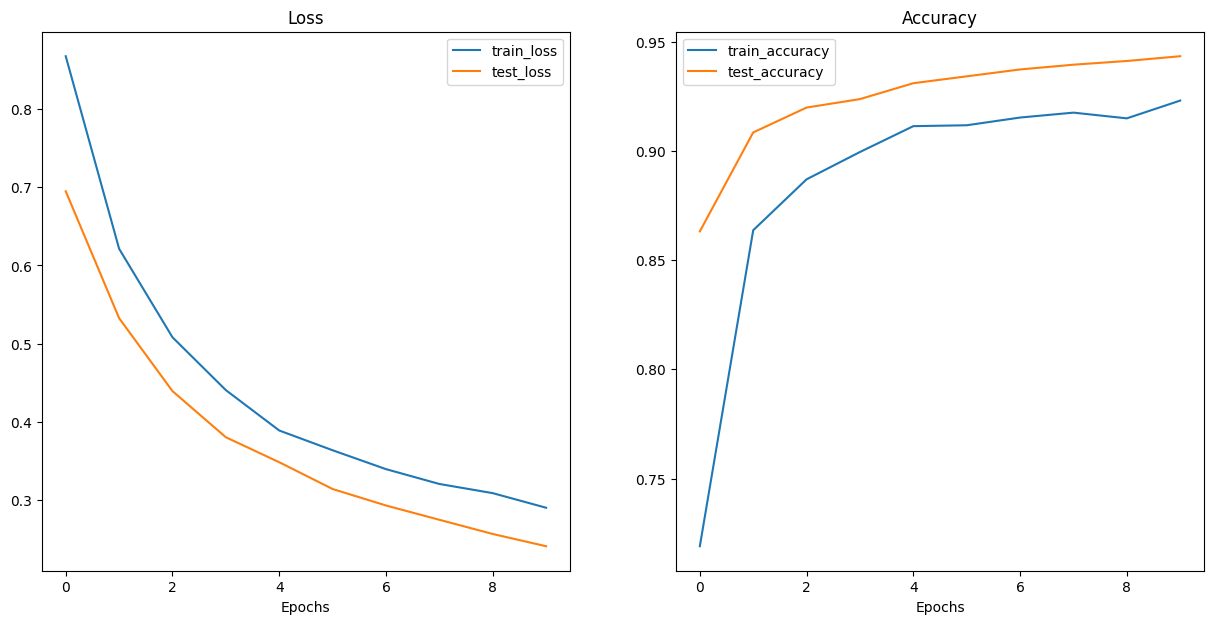

In [18]:
plot_loss_curves(effnetb2_results)

# Saving model

As the Accuracy % is near about 94% we would want to save data for further prediction on data which model may not have seen.


In [19]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [20]:
save_model(model=effnetb2_model,
           target_dir="models",
           model_name='effnetb2_model_eurosat_10_epochs.pth')

[INFO] Saving model to: models/effnetb2_model_eurosat_10_epochs.pth


# Predicting on outside data

With this function we can predict the images of land using satelite to classify the usage of land.

In [21]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",):
   # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

# Predicting image

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


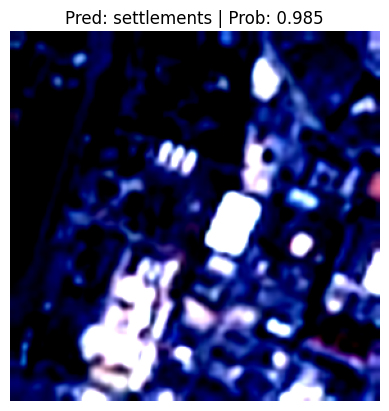

In [47]:
example_img=Path('/content/map_data/test/settlements/Industrial_1033.jpg')
pred_and_plot_image(model= effnetb2_model,
                    image_path=example_img,
                    class_names= class_names,
                    transform=effnetb2_transforms)